# This notebook analyses data from Bpod.

## Tested on output of protocol 'Two_Alternative_Choice'

***
** Import stuff and select animals **
***

In [1]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain

warnings.filterwarnings('ignore')

In [3]:
# output a list of animals ready to pull
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

All_Animals = []
for AnimalID in os.listdir(GeneralDirectory):
    DFfile = GeneralDirectory + AnimalID + BpodProtocol + AnimalID + '_dataframe.pkl'
    if os.path.exists(DFfile):
        print('Found data for ' + AnimalID)
        All_Animals.append(AnimalID)


In [80]:
# Select animals to analyze
#AnimalIDList = ['C01', 'C02', 'C03', 'Ot01', 'Ot02', 'Ot03', 'Os02', 'Os03']
#AnimalIDList = ['C01', 'C02', 'C03', 'N01', 'N02', 'N03', 'N05']
#AnimalIDList = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'N06']
#AnimalIDList = ['Ot01', 'Ot02', 'Ot03']

AIDList = ['C01','C02','C03','C04','C05','C06',
                'DRD101','DRD102','DRD103','DRD104','DRD105','DRD106','DRD107','DRD108',
                'N01','N02','N03','N05','N06',
                'pdyn01','pdyn02','pdyn03','pdyn04',
                'Somcre04','Somcre05','Somcre06','Somcre07','Somcre08','Somcre09',
                'SomFlp01','SomFlp02','SomFlp03']

# Muscimol
AIDList = ['pdyn01','pdyn03','pdyn04','T01','T03']

AIDList = All_Animals

# Drd1KO
#AIDList = ['DRD101','DRD102','DRD103','DRD104','DRD105','DRD106','DRD107','DRD108']

# Caspase-POST
AIDList = ['FITM01', 'FITM02', 'FITM03',
           'CTRL01', 'CTRL02', 'CTRL03', 'CTRL04',
           'A2A04', 'A2A05', 'A2A06', 'A2A07']


# Name the output directory
#output_directory_name = '-'.join(AIDList)
#output_directory_name = 'Muscimol'
output_directory_name = 'All_Animals'
#output_directory_name = 'Drd1KO'


# Create out directory if it does not exist
outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

In [28]:
# Read the dataframes and merge them
DataFrames = []
for AID in AIDList:
    DFfile = GeneralDirectory + AID + BpodProtocol + AID + '_dataframe.pkl'
    ADF = pd.read_pickle(DFfile)
    DataFrames.append(ADF)
AnimalsDF = pd.concat(DataFrames, ignore_index=True)

ValueError: No objects to concatenate

In [ ]:
# Save the dataframe
AnimalsDF.to_pickle(outputDir + output_directory_name + '_dataframe.pkl')

In [81]:
# Read the dataframe
AnimalsDF = pd.read_pickle(outputDir + output_directory_name + '_dataframe.pkl')

In [34]:
# get a list of each animalID in each condition
for EG in pd.unique(AnimalsDF.ExperimentalGroup):
    print(str(EG) + ':')
    for AI in pd.unique(AnimalsDF[AnimalsDF.ExperimentalGroup == EG].AnimalID):
        print('  ' + AI)

D1Cre-caspase-post:
  FITM01
  FITM02
  FITM03
Control:
  CTRL01
  CTRL02
  CTRL03
  CTRL04
D2Cre-caspase-post:
  A2A04
  A2A05
  A2A06
  A2A07


In [52]:
# Restrict dataset
# select only some experimental conditions
expgr_to_select = ['CortexBuffer', '6OHDAtail', 'D2Cre-caspase-post', 'D1Cre-caspase-post', 'Control']
expgr_to_select = ['CortexBuffer', 'Drd1tailKO']
AnimalsDF = AnimalsDF[AnimalsDF.ExperimentalGroup.isin(expgr_to_select)]

***
##### CALCULATE STUFF
***

In [83]:
# Create a unique ID for every session
def mergeStrings(df):
    return df['AnimalID'] + ' ' + df['SessionTime']

AnimalsDF['SessionID'] = AnimalsDF[['AnimalID', 'SessionTime']].apply(mergeStrings, axis=1)

In [84]:
# Create a cumulative trial number for every animal BE AWARE THAT SESSIONS MIGHT HAVE BEEN REMOVED BEFORE SO THIS NUMBER IS NOT EXACT
CumTrialsList = []
for Aid in pd.unique(AnimalsDF['AnimalID']):
    CumTrialsList.append(np.arange(len(AnimalsDF[AnimalsDF['AnimalID']==Aid])) + 1)
# flatten the list of lists
AnimalsDF['CumulativeTrialNumber'] = np.array(list(chain(*[x for x in CumTrialsList])))

In [85]:
# Restart the count of CumulativeTrialNumber for every protocol
AnimalsDF['CumulativeTrialNumberByProtocol'] = np.nan

for Aid in pd.unique(AnimalsDF['AnimalID']):
    for Prot in pd.unique(AnimalsDF['Protocol']):
        conditions = np.logical_and(AnimalsDF['AnimalID']==Aid, AnimalsDF['Protocol']==Prot)
        AnimalsDF.CumulativeTrialNumberByProtocol.loc[AnimalsDF[conditions].index] = \
        np.arange(len(AnimalsDF[conditions])) + 1
            

In [86]:
# Calculate performance of the past X trials
PAST_WINDOW = 20
CumPerList = []
for Sid in pd.unique(AnimalsDF['SessionID']):
    CumPerList.append(cuf.perf_window_calculator(AnimalsDF[AnimalsDF['SessionID']==Sid], PAST_WINDOW))
# flatten the list of lists
AnimalsDF['CurrentPastPerformance'] = np.array(list(chain(*[x for x in CumPerList])))

In [87]:
# Number of pokes in the center
AnimalsDF['NoOfCenterPokes'] = AnimalsDF[['TrialEvents', 'TrialStates']].apply(cuf.CalculateMidPokes, axis=1)

In [88]:
# Time waiting in the middle
AnimalsDF['MiddleWaitTime'] = AnimalsDF[['TrialEvents', 'TrialStates']].apply(cuf.MidPortWait, axis=1)

In [89]:
# Time they take to innitiate the trial
AnimalsDF['TrialInitiationTime'] = AnimalsDF[['TrialEvents']].apply(cuf.CalculateTrialInitiationTime, axis=1)

In [90]:
# Calculate the right bias
AnimalsDF['RightBias'] = cuf.CalculateRBiasWindow(np.array(AnimalsDF['FirstPoke']),\
                                                              np.array(AnimalsDF['FirstPokeCorrect']), 50)

In [91]:
# Calculate speed over the surrounding 6 trials
SP_WINDOW = 6
speed_list = []
for Sid in pd.unique(AnimalsDF['SessionID']):
    speed_list.append(cuf.speed_window_calculator(AnimalsDF[AnimalsDF['SessionID']==Sid], SP_WINDOW))
# flatten the list of lists
AnimalsDF['TrialsSpeed'] = np.array(list(chain(*[x for x in speed_list])))

In [92]:
# name your dataset for plotting
df_to_plot = AnimalsDF

In [63]:
#Select conditions

# include only the easy trials
condition1 = np.logical_or(AnimalsDF['TrialSequence']==1, AnimalsDF['TrialSequence']==7)
conditions = condition1

# include only trials without stimulation
condition2 = AnimalsDF['OptoStim'] == 0
conditions = np.logical_and(conditions, condition2)

# remove trials in which the animal is too biased
'''
RBlimit = 0.25
condition3 = np.logical_and(AnimalsDF['RightBias'] > (-RBlimit), AnimalsDF['RightBias'] < RBlimit)
conditions = np.logical_and(conditions, condition3)
'''
# remove the trials at the beginning of the session
condition4 = AnimalsDF['TrialIndex'] > 10
conditions = np.logical_and(conditions, condition4)

# remove the Aud_Psycho
condition5 = ~(AnimalsDF['Protocol'] == 'Aud_Psycho')
conditions = np.logical_and(conditions, condition5)

# select only some protocols
prot_to_select = ['Auditory']
condition6 = AnimalsDF.Protocol.isin(prot_to_select)
conditions = np.logical_and(conditions, condition6)

# select only some experimental conditions
'''
expgr_to_select = ['CortexBuffer', '6OHDAtail']  #, 'ToSprojecting-BLAcaspase']
condition7 = AnimalsDF.ExperimentalGroup.isin(expgr_to_select)
conditions = np.logical_and(conditions, condition7)
'''
# remove some animals
'''
animals_to_remove = ['DRD104']
condition8 = ~AnimalsDF.AnimalID.isin(animals_to_remove)
conditions = np.logical_and(conditions, condition8)
'''

# select some animals
'''
animals_to_select = ['C01', 'C02', 'C03', 'PV01', 'PV02', 'PV03', 'PV04', 'PV05', 'PV06',
       'SomFlp04', 'SomFlp06', 'SomFlp07', 'SomFlp08', 'SomFlp09']
condition9 = AnimalsDF.AnimalID.isin(animals_to_select)
conditions = np.logical_and(conditions, condition9)
'''

# select trials up to a certain number
trials_up_to = 5000
condition10 = AnimalsDF['CumulativeTrialNumberByProtocol'] < trials_up_to
conditions = np.logical_and(conditions, condition10)

df_to_plot = AnimalsDF[conditions]

In [64]:
df_to_plot.AnimalID.unique()

array(['C01', 'C02', 'C03', 'DRD101', 'DRD102', 'DRD103', 'DRD104',
       'DRD105', 'DRD106', 'DRD107', 'DRD108', 'SomFlp04', 'SomFlp06'],
      dtype=object)

In [94]:
#calculate if the previous trial was a success or not
df_to_plot['PrevTrialSuccess'] = np.insert(np.array(df_to_plot['FirstPokeCorrect'][:-1]), 0, np.nan)

In [95]:
# Create new output dir
#output_directory_name = 'DRD1KO_Apr2020'
outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

In [96]:
# Save the dataframe
df_to_plot.to_pickle(outputDir + output_directory_name + '_dataframe.pkl')

***
#### Get a summary of all the mice in the dataset

Progress: [####################] 100.0%


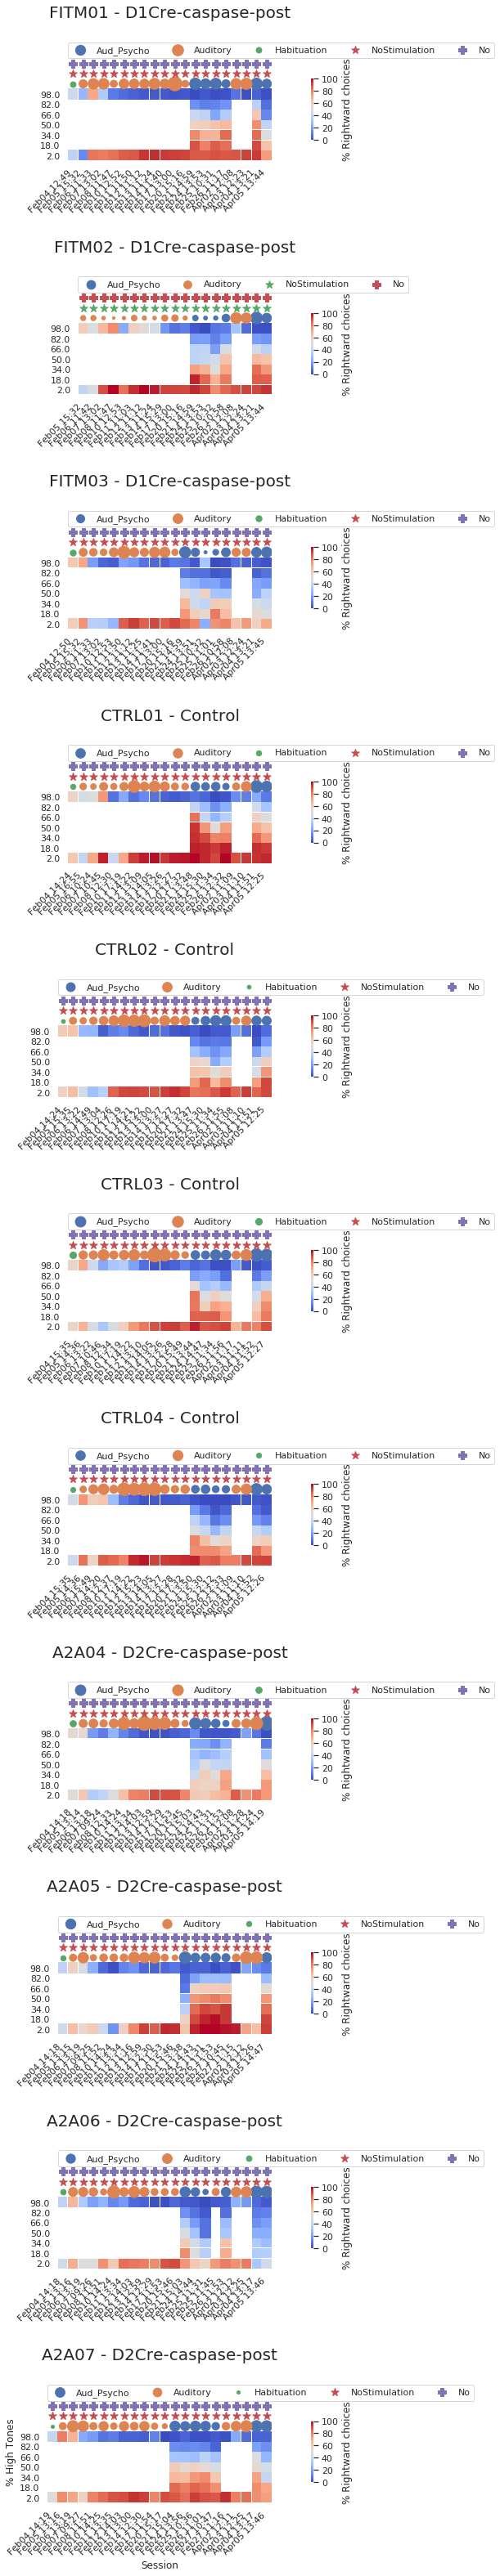

In [93]:
# plot a summary of all the animals in the dataset
fig, ax = plt.subplots(len(pd.unique(df_to_plot.AnimalID)), 1, figsize=(17,5 * len(pd.unique(df_to_plot.AnimalID))))
axs = ax.ravel()
fig.subplots_adjust(hspace=1.3)
for i, animal in enumerate(pd.unique(df_to_plot.AnimalID)):
    aDF = df_to_plot[df_to_plot.AnimalID == animal]
    dfToPlot = plot_utils.summary_matrix(aDF)
    axs[i] = plot_utils.summary_plot(dfToPlot, aDF, axs[i])
    
plt.savefig(outputDir + 'psychometricPerformanceAllSessionsHeatmap.pdf', transparent=True,dpi = 500, bbox_inches='tight')
plt.show(fig)

In [69]:
# remove some animals
animals_to_remove = ['SomCre05', 'SomCre06', 'SomCre07', 'SomCre08', 'SomCre09']
df_to_plot = df_to_plot[~AnimalsDF.AnimalID.isin(animals_to_remove)]


In [42]:
np.unique(df_to_plot.Protocol)

array(['Auditory'], dtype=object)

***
**Plot the evolution of the cumulative performance**
***

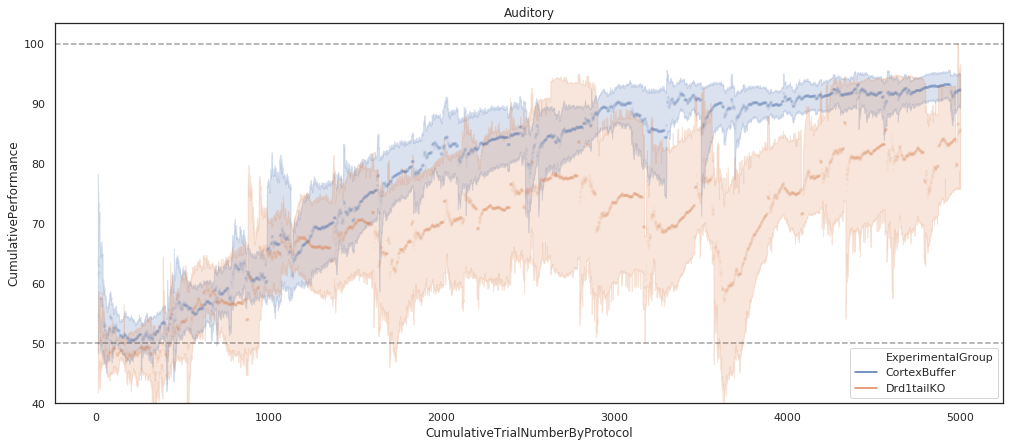

In [76]:
column_to_plot = 'CumulativePerformance'

fig, axs = plt.subplots(len(pd.unique(df_to_plot['Protocol'])), 1, figsize=(17,7 * len(pd.unique(df_to_plot['Protocol']))), sharex=True)
if axs.numRows > 1:
    axs = axs.ravel()
else:
    axs = [axs,]
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(df_to_plot['Protocol'])):
    sns.lineplot(x='CumulativeTrialNumberByProtocol', y=column_to_plot,
                 data=df_to_plot[df_to_plot['Protocol']==prot],
                 ax=axs[ax], hue='ExperimentalGroup', 
                 marker=".", alpha=0.05, markeredgewidth=0, linewidth=0)
                 # the following line splits the data and does not compute confidence intervals and mean
                 #units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=40)
    '''
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    '''
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
#plt.savefig(outputDir + column_to_plot + 'ByProtocol_Grouped_AnimalSelection.pdf',
plt.savefig(outputDir + column_to_plot + 'ByProtocol_Grouped.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

***
#### Plot a summary of different parameters

In [45]:
#df_to_plot = df_to_plot[np.logical_or(df_to_plot.Protocol == 'Visual', df_to_plot.Protocol == 'Auditory')]

In [ ]:
#TODO: Identify the outliers below. This violin plots suck

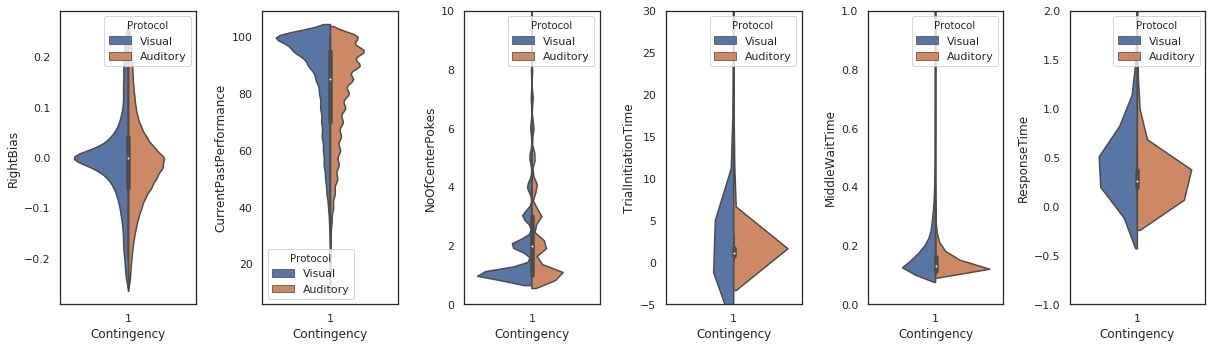

In [28]:
columns_to_plot = ['RightBias', 'CurrentPastPerformance', 'NoOfCenterPokes', 'TrialInitiationTime',\
                   'MiddleWaitTime', 'ResponseTime']
fig, ax = plt.subplots(1, len(columns_to_plot), figsize=(17, 5))
ax = ax.ravel()
for i, col in enumerate(columns_to_plot):
    # Contingency is a hack for splitting
    sns.violinplot(x='Contingency', y=col, hue='Protocol', data=df_to_plot, split=True, scale='area', ax=ax[i])
ax[2].set_ylim(0, 10)
ax[3].set_ylim(-5, 30)
#ax[3].set_yscale('log')
ax[4].set_ylim(0, 1)
#ax[5].set_yscale('log')
ax[5].set_ylim(-1, 2)
plt.tight_layout()
        
plt.savefig(outputDir + 'General_Parameters.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

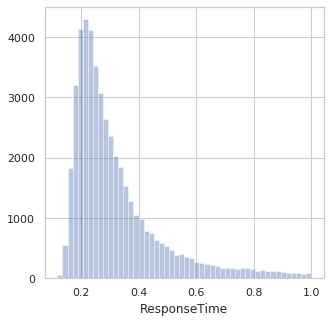

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#sns.distplot(df_to_plot[df_to_plot['NoOfCenterPokes']<6]['NoOfCenterPokes'], kde=False, ax=ax, bins=5)
#sns.distplot(df_to_plot[df_to_plot['TrialInitiationTime']<5]['TrialInitiationTime'], kde=False, ax=ax, bins=50)
#sns.distplot(df_to_plot[df_to_plot['MiddleWaitTime']<.3]['MiddleWaitTime'], kde=False, ax=ax, bins=50)
sns.distplot(df_to_plot[df_to_plot['ResponseTime']<1]['ResponseTime'], kde=False, ax=ax, bins=50)


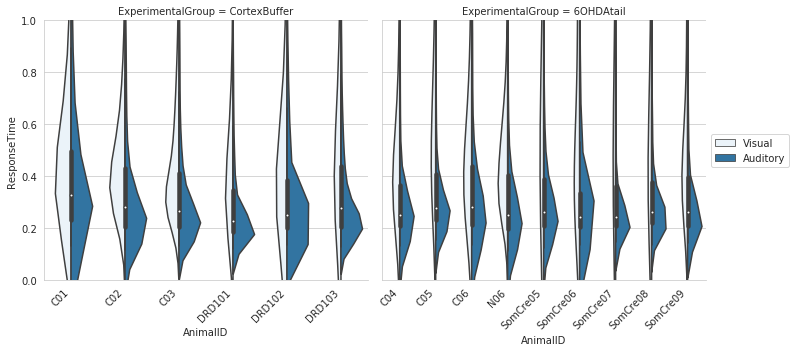

In [254]:
# split by mice
column_to_plot = 'ResponseTime'
grid = sns.FacetGrid(df_to_plot[df_to_plot[column_to_plot]<20], col="ExperimentalGroup", sharex=False, height=5)
grid.fig.tight_layout()
for i in range(len(df_to_plot.ExperimentalGroup.unique())):
    grid.axes[0,i].set_ylim(0, 1)
grid.set_xticklabels(rotation=45, horizontalalignment="right")
grid.map_dataframe(sns.violinplot, "AnimalID", column_to_plot, hue='Protocol', split=True)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.savefig(outputDir + column_to_plot + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [48]:
# Check the number of sessions needed to get to 4000 auditory trials
aids = []
tottrials = []
totsessions = []
egr = []
for AID in df_to_plot.AnimalID.unique():
    aids.append(AID)
    egr.append(df_to_plot[df_to_plot['AnimalID'] == AID].ExperimentalGroup.unique()[0])
    tottrials.append(np.max(df_to_plot[df_to_plot['AnimalID'] == AID].CumulativeTrialNumberByProtocol))
    totsessions.append(len(df_to_plot[df_to_plot['AnimalID'] == AID].SessionID.unique()))

dfToPlot = pd.DataFrame({'AnimalID': aids,
                        'ExperimentalGroup': egr,
                        'TotalTrials': tottrials,
                        'TotalSessions': totsessions})

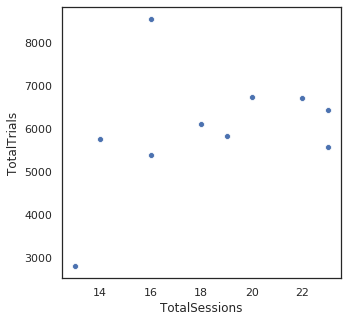

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
sns.scatterplot(x='TotalSessions', y='TotalTrials', hue='ExperimentalGroup', data=dfToPlot)


Create a simpler plot calculating the performance of the day


In [71]:
# Day of training
def getDay(df):
    return df.SessionTime.split(' ')[0]
    
df_to_plot['TrainingDay'] = df_to_plot.apply(getDay, axis=1)

In [72]:
# generate a new dataset to get the data
dfForPlot = cuf.AnalyzePercentageByDay(df_to_plot)

In [73]:
# For each animal and protocol, calculate the session count for that protocol
# ProtocolCount
dfForPlot['ProtocolCount'] = np.nan
for animal in pd.unique(dfForPlot['AnimalID']):
    for protocol in pd.unique(dfForPlot['Protocol']):
        conditions = np.logical_and(dfForPlot['AnimalID']==animal, dfForPlot['Protocol']==protocol)
        dfForPlot.ProtocolCount.loc[dfForPlot[conditions].index] = \
        np.arange(len(dfForPlot[conditions])) + 1

In [74]:
# calculate the cumulative sum of trials by protocol
dfForPlot['TrialCumSumByProtocol'] = np.nan
for animal in pd.unique(dfForPlot['AnimalID']):
    for protocol in pd.unique(dfForPlot['Protocol']):
        conditions = np.logical_and(dfForPlot['AnimalID']==animal, dfForPlot['Protocol']==protocol)
        dfForPlot.TrialCumSumByProtocol.loc[dfForPlot[conditions].index] = \
        np.cumsum(dfForPlot[conditions].NumberOfTrials)

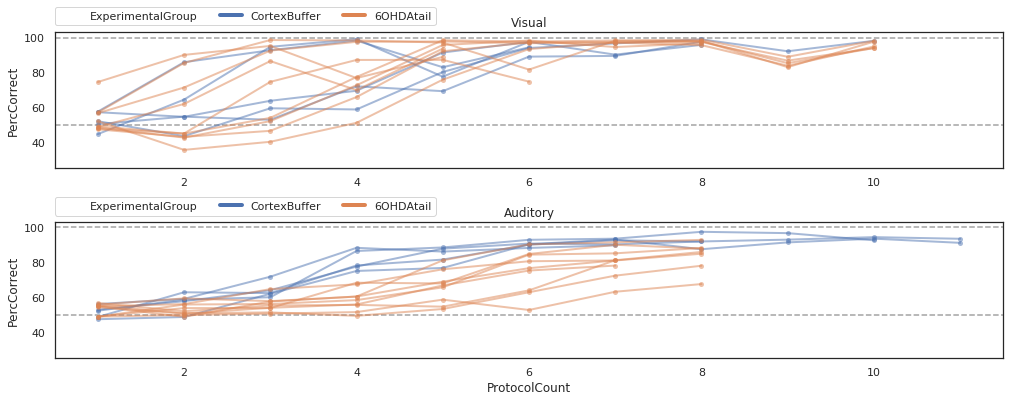

In [75]:
fig, axs = plt.subplots(len(np.unique(dfForPlot['Protocol'])),1, figsize=(17,3*len(np.unique(dfForPlot['Protocol']))), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.4)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(dfForPlot['Protocol'])):
    sns.lineplot(x='ProtocolCount', y='PercCorrect',
                 data=dfForPlot[dfForPlot['Protocol']==prot],
                 ax=axs[ax], hue='ExperimentalGroup', 
                 marker=".", alpha=0.5, markeredgewidth=0, linewidth=2, markersize=10,#)
                 # the following line splits the data and does not compute confidence intervals and mean
                 units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=25)
    
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(outputDir + 'SessionPercCorrectByProtocol.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#sns.barplot(x='SessionTime', y='PercCorrect', hue='AnimalID', data=dfForPlot)

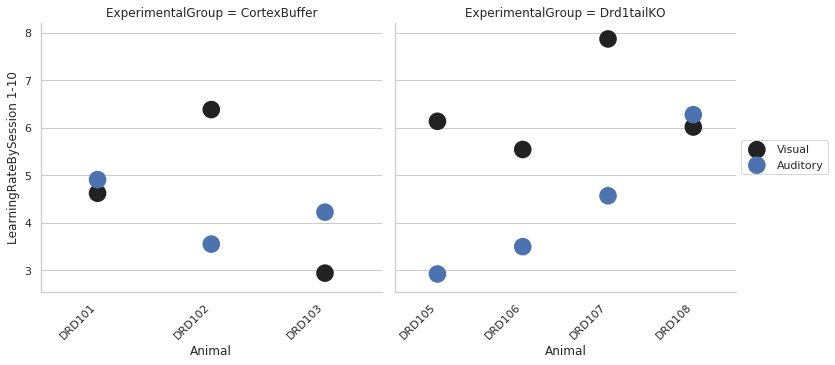

In [66]:
### CHECK THIS AND BELOW PROPERLY

# Calculate the rate of learning by animal for the first X sessions
# fit a model per animal and calculate the coefficient and plot
from_session = 1
to_session = 10
from sklearn.linear_model import LinearRegression
learning_rate_df = pd.DataFrame(columns=['AnimalID', 'ExperimentalGroup', 'Protocol', 'LearningRateBySession'])
for animal in dfForPlot.AnimalID.unique():
    for protocol in dfForPlot.Protocol.unique():
        df = dfForPlot[(dfForPlot.AnimalID == animal) & (dfForPlot.Protocol == protocol)]
        # fit model
        x = df[(df.ProtocolCount >= from_session) & (df.ProtocolCount <= to_session)].ProtocolCount
        y = df[(df.ProtocolCount >= from_session) & (df.ProtocolCount <= to_session)].PercCorrect
        lrmodel = LinearRegression().fit(x[:, np.newaxis], y)
        learning_rate_df = learning_rate_df.append({
            'AnimalID': animal,
            'ExperimentalGroup': df.ExperimentalGroup.unique()[0],
            'Protocol': protocol,
            'LearningRateBySession': lrmodel.coef_[0]
        }, ignore_index=True)
        
# plot
sns.set_style('whitegrid')
grid = sns.FacetGrid(learning_rate_df, col="ExperimentalGroup", sharex=False, sharey=True, height=5, col_wrap=5)
grid.set_xticklabels(rotation=45, horizontalalignment="right")
grid = grid.map_dataframe(sns.pointplot, x="AnimalID", y="LearningRateBySession", hue='Protocol',
                          dodge=0, join=False, markers="o", scale=2)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
grid.axes[0].set_xlabel('Animal')
grid.axes[1].set_xlabel('Animal')
grid.axes[0].set_ylabel('LearningRateBySession ' + str(from_session) + '-' + str(to_session))
plt.savefig(outputDir + 'LearningRateBySessionCoef_' + str(from_session) + '-' + str(to_session) + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

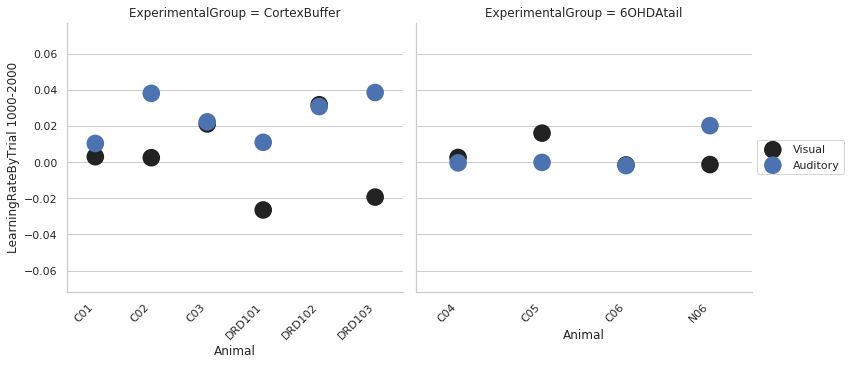

In [64]:
# Calculate the rate of learning by animal for the first X trials
# fit a model per animal and calculate the coefficient and plot
from_trial = 1000
to_trial = 2000
from sklearn.linear_model import LinearRegression
learning_rate_df = pd.DataFrame(columns=['AnimalID', 'ExperimentalGroup', 'Protocol', 'LearningRateByTrial'])
for animal in df_to_plot.AnimalID.unique():
    for protocol in df_to_plot.Protocol.unique():
    #protocol = 'Visual'
        df = df_to_plot[(df_to_plot.AnimalID == animal) & (df_to_plot.Protocol == protocol)]
        # fit model
        x = df[(df.CumulativeTrialNumberByProtocol >= from_trial) & (df.CumulativeTrialNumberByProtocol <= to_trial)].CumulativeTrialNumberByProtocol
        y = df[(df.CumulativeTrialNumberByProtocol >= from_trial) & (df.CumulativeTrialNumberByProtocol <= to_trial)].CurrentPastPerformance
        # drop NAs
        nan_mask = ~(np.isnan(x) | np.isnan(y))
        lrmodel = LinearRegression().fit(x[nan_mask, np.newaxis], y[nan_mask])
        learning_rate_df = learning_rate_df.append({
            'AnimalID': animal,
            'ExperimentalGroup': df.ExperimentalGroup.unique()[0],
            'Protocol': protocol,
            'LearningRateByTrial': lrmodel.coef_[0]
        }, ignore_index=True)
        
# plot
sns.set_style('whitegrid')
grid = sns.FacetGrid(learning_rate_df, col="ExperimentalGroup", sharex=False, sharey=True, height=5, col_wrap=5)
grid.set_xticklabels(rotation=45, horizontalalignment="right")
grid = grid.map_dataframe(sns.pointplot, x="AnimalID", y="LearningRateByTrial", hue='Protocol',
                          dodge=0, join=False, markers="o", scale=2)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
grid.axes[0].set_xlabel('Animal')
grid.axes[1].set_xlabel('Animal')
grid.axes[0].set_ylabel('LearningRateByTrial ' + str(from_trial) + '-' + str(to_trial))
plt.savefig(outputDir + 'LearningRateByTrialCoef_' + str(from_trial) + '-' + str(to_trial) + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [57]:
df_to_plot.Protocol.unique()

array(['Visual', 'Auditory'], dtype=object)

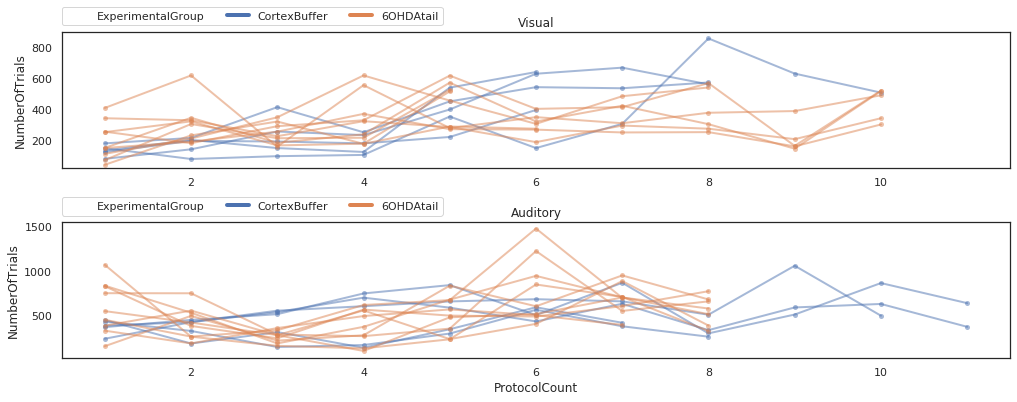

In [76]:
# Number of trials per session
fig, axs = plt.subplots(len(np.unique(dfForPlot['Protocol'])),1, figsize=(17,3*len(np.unique(dfForPlot['Protocol']))), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.4)

for ax, prot in enumerate(pd.unique(dfForPlot['Protocol'])):
    sns.lineplot(x='ProtocolCount', y='NumberOfTrials',
                 data=dfForPlot[dfForPlot['Protocol']==prot],
                 ax=axs[ax], hue='ExperimentalGroup', 
                 marker=".", alpha=0.5, markeredgewidth=0, linewidth=2, markersize=10,
                 # the following line splits the data and does not compute confidence intervals and mean
                 units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=25)
    
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(outputDir + 'NumberOfTrialsByProtocol_grouped.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#sns.barplot(x='SessionTime', y='PercCorrect', hue='AnimalID', data=dfForPlot)

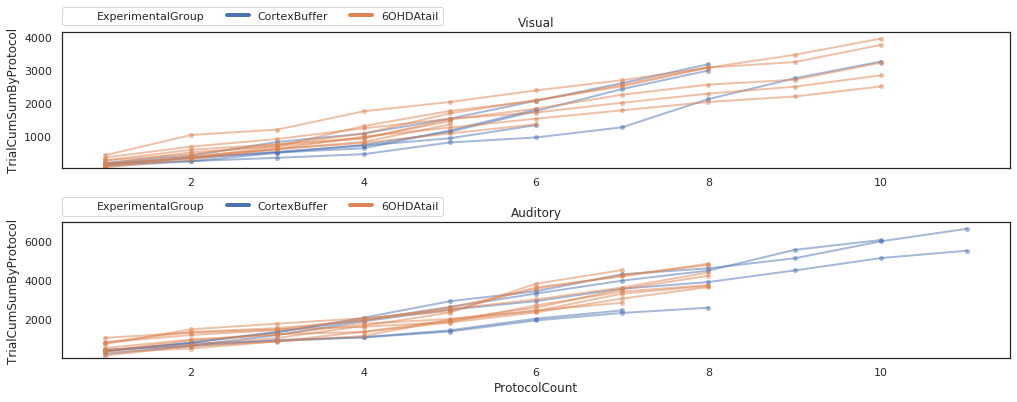

In [77]:
# do this in a cumulative way
fig, axs = plt.subplots(len(np.unique(dfForPlot['Protocol'])),1, figsize=(17,3*len(np.unique(dfForPlot['Protocol']))), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.4)

for ax, prot in enumerate(pd.unique(dfForPlot['Protocol'])):
    sns.lineplot(x='ProtocolCount', y='TrialCumSumByProtocol',
                 data=dfForPlot[dfForPlot['Protocol']==prot],
                 ax=axs[ax], hue='ExperimentalGroup', 
                 marker=".", alpha=0.5, markeredgewidth=0, linewidth=2, markersize=10,
                 # the following line splits the data and does not compute confidence intervals and mean
                 units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=25)
    
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(outputDir + 'NumberOfTrialsByProtocol_Cumulative.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [64]:
np.std(dfForPlot.NumberOfTrials)

270.25784261133236

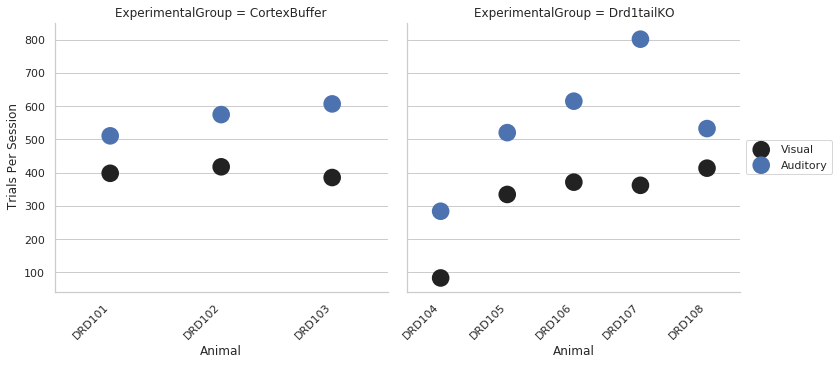

In [36]:
# fit a model per animal and calculate the coefficient and plot
from sklearn.linear_model import LinearRegression
tr_per_ss_df = pd.DataFrame(columns=['AnimalID', 'ExperimentalGroup', 'Protocol', 'TrialsPerSessionCoef'])
for animal in dfForPlot.AnimalID.unique():
    for protocol in dfForPlot.Protocol.unique():
        df = dfForPlot[(dfForPlot.AnimalID == animal) & (dfForPlot.Protocol == protocol)]
        # fit model
        x = df.ProtocolCount
        y = df.TrialCumSumByProtocol
        lrmodel = LinearRegression().fit(x[:, np.newaxis], y)
        tr_per_ss_df = tr_per_ss_df.append({
            'AnimalID': animal,
            'ExperimentalGroup': df.ExperimentalGroup.unique()[0],
            'Protocol': protocol,
            'TrialsPerSessionCoef': lrmodel.coef_[0]
        }, ignore_index=True)
        
# plot
sns.set_style('whitegrid')
grid = sns.FacetGrid(tr_per_ss_df, col="ExperimentalGroup", sharex=False, sharey=True, height=5, col_wrap=5)
grid.set_xticklabels(rotation=45, horizontalalignment="right")
grid = grid.map_dataframe(sns.pointplot, x="AnimalID", y="TrialsPerSessionCoef", hue='Protocol',
                          dodge=0, join=False, markers="o", scale=2)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
grid.axes[0].set_xlabel('Animal')
grid.axes[1].set_xlabel('Animal')
grid.axes[0].set_ylabel(' Trials Per Session')
plt.savefig(outputDir + 'TrialsPerSessionCoef.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

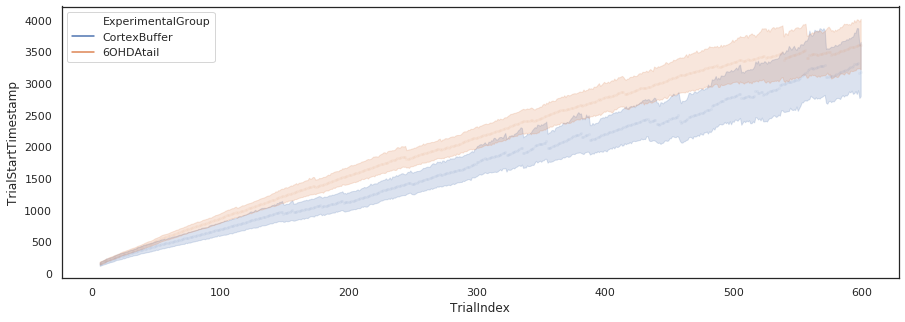

In [78]:
# plot the number of trials per session as a function of time for a Protocol and the first 600 trials
protocol = 'Auditory'
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialStartTimestamp',
             data=df_to_plot[(df_to_plot.Protocol == protocol) & (df_to_plot.TrialIndex < 600)],
             ax=ax, hue='ExperimentalGroup', 
             marker=".", alpha=0.05, markeredgewidth=0, linewidth=0)
             # the following line splits the data and does not compute confidence intervals and mean
             #units="AnimalID", estimator=None)
plt.savefig(outputDir + 'TrialStartTimefor' + protocol + '.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

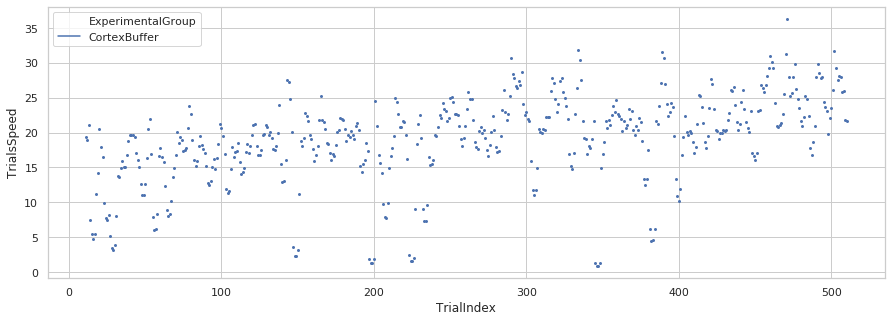

In [85]:
# plot the speed per session as a function of time
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialsSpeed',
             data=df_to_plot[df_to_plot.SessionID==df_to_plot.SessionID.unique()[10]],
             ax=ax, hue='ExperimentalGroup', 
             marker=".", alpha=1, markeredgewidth=0, linewidth=0,
             # the following line splits the data and does not compute confidence intervals and mean
             units="AnimalID", estimator=None)

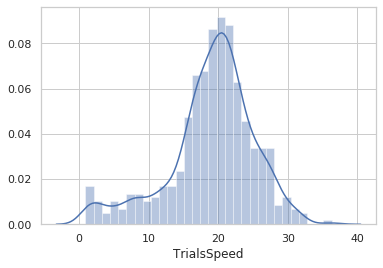

In [102]:
# plot the speed per session as a function of time
data = df_to_plot[df_to_plot.SessionID==df_to_plot.SessionID.unique()[10]]
#fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(data.TrialsSpeed.dropna(), bins=30, norm_hist=True)

ValueError: min() arg is an empty sequence

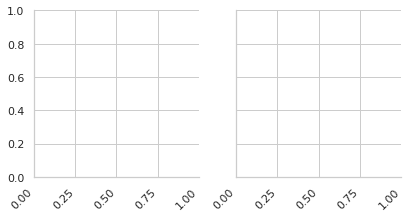

In [107]:
# This might have problems if the punish time was not the same for all
# split by mice
sns.set_style(style=None, rc=None)
protocol = 'Auditory'
column_to_plot = 'TrialsSpeed'
grid = sns.FacetGrid(df_to_plot[df_to_plot.Protocol == protocol], hue='ExperimentalGroup', col="ExperimentalGroup", sharex=False)#, height=5)
grid.fig.tight_layout()
#for i in range(len(df_to_plot.ExperimentalGroup.unique())):
#    grid.axes[0,i].set_ylim(0.1, 6)
grid.set_xticklabels(rotation=45, horizontalalignment="right")
grid.map_dataframe(sns.violinplot, "AnimalID", column_to_plot)
plt.savefig(outputDir + column_to_plot + '_' + protocol + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

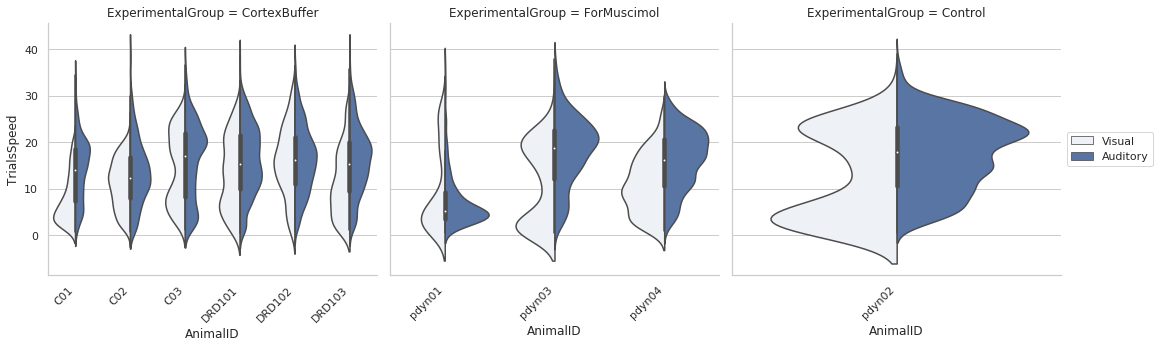

In [71]:
# Calculate the speed difference between the visual and the auditory in between a certain percentage
low_perc = 65
high_perc = 90
conditions = (df_to_plot.CurrentPastPerformance > low_perc) & (df_to_plot.CurrentPastPerformance < high_perc)

column_to_plot = 'TrialsSpeed'
grid = sns.FacetGrid(df_to_plot[conditions], col="ExperimentalGroup", sharex=False, height=5)
grid.fig.tight_layout()
#for i in range(len(df_to_plot.ExperimentalGroup.unique())):
#    grid.axes[0,i].set_ylim(0.1, 6)
grid.set_xticklabels(rotation=45, horizontalalignment="right")
grid.map_dataframe(sns.violinplot, "AnimalID", column_to_plot, hue='Protocol', split=True)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.savefig(outputDir + column_to_plot + '_protocolComparison_' + str(low_perc) + '-' + str(high_perc) + '.pdf',
            transparent=True, bbox_inches='tight')

plt.show()

In [88]:
# Calculate the differences with the medians
med_speed_df = pd.DataFrame(columns=['AnimalID', 'ExperimentalGroup', 'Protocol', 'Median', 'Mean'])
for animal in df_to_plot.AnimalID.unique():
    for protocol in df_to_plot.Protocol.unique():
        df = df_to_plot[conditions &
                    (df_to_plot.AnimalID == animal) &
                    (df_to_plot.Protocol == protocol)]

        med_speed_df = med_speed_df.append({
            'AnimalID': animal,
            'ExperimentalGroup': df.ExperimentalGroup.unique()[0],
            'Protocol': protocol,
            'Median': np.nanmedian(df.TrialsSpeed),
            'Mean': np.nanmean(df.TrialsSpeed)
        }, ignore_index=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

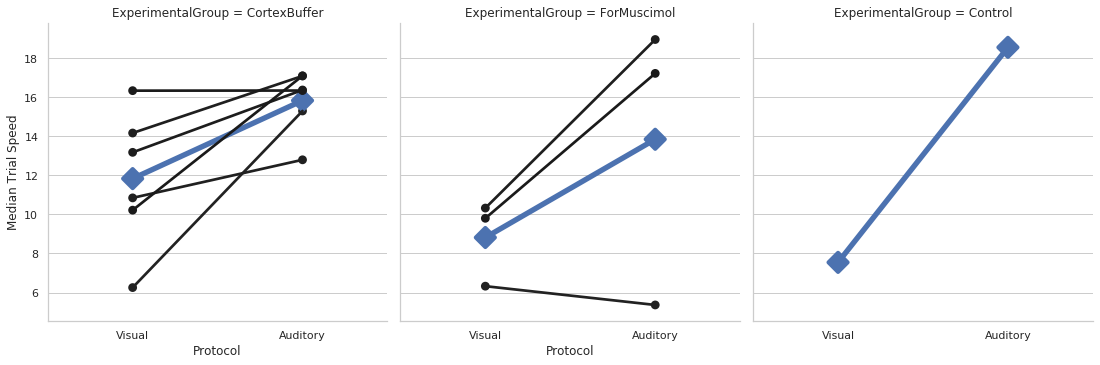

In [73]:
sns.set_style('whitegrid')
col_to_plot = 'Median'
grid = sns.FacetGrid(med_speed_df, col="ExperimentalGroup", sharex=False, sharey=True, height=5, col_wrap=5)
grid = grid.map_dataframe(sns.pointplot, x="Protocol", y=col_to_plot, hue="AnimalID",
                          dodge=0, join=True, markers="o", scale=1, ci=False, alpha=0.1, color = 'k')
grid = grid.map_dataframe(sns.pointplot, x="Protocol", y=col_to_plot,
                          dodge=0, join=True, markers="D", scale=2, ci=True)
#plt.legend(loc='center left',bbox_to_anchor=(1,0.5), title="SwitchSide")
grid.axes[0].set_xlabel('Protocol')
grid.axes[1].set_xlabel('Protocol')
grid.axes[0].set_ylabel(col_to_plot + ' Trial Speed')
plt.savefig(outputDir + col_to_plot + 'TrialSpeedProtocolComparison_' + str(low_perc) + '-' + str(high_perc) + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [94]:
# plot, per animal, the decrease/increase of speed
ratio_speed_df = pd.DataFrame(columns=['AnimalID', 'ExperimentalGroup', 'MedianRatio', 'MeanRatio'])
for animal in med_speed_df.AnimalID.unique():
    df = med_speed_df[med_speed_df.AnimalID == animal]
    ratio_speed_df = ratio_speed_df.append({
        'AnimalID': animal,
        'ExperimentalGroup': df.ExperimentalGroup.unique()[0],
        'MedianRatio': float(df[df.Protocol == 'Auditory'].Median) / float(df[df.Protocol == 'Visual'].Median),
        'MeanRatio': float(df[df.Protocol == 'Auditory'].Mean) / float(df[df.Protocol == 'Visual'].Mean)
    }, ignore_index=True)

# plot
sns.set_style('whitegrid')
col_to_plot = 'MeanRatio'
grid = sns.FacetGrid(ratio_speed_df, col="ExperimentalGroup", sharex=False, sharey=True, height=5, col_wrap=5)
grid.set_xticklabels(rotation=45, horizontalalignment="right")
grid = grid.map_dataframe(sns.pointplot, x="AnimalID", y=col_to_plot,
                          dodge=0, join=False, markers="D", scale=1)
#plt.legend(loc='center left',bbox_to_anchor=(1,0.5), title="SwitchSide")
grid.axes[0].set_xlabel('Animal')
grid.axes[1].set_xlabel('Animal')
grid.axes[0].set_ylabel(col_to_plot + ' Increase in Trial Speed')
plt.savefig(outputDir + col_to_plot + 'SpeedProtocolComparison_' + str(low_perc) + '-' + str(high_perc) + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

TypeError: cannot convert the series to <class 'float'>

In [38]:
# check the effect of the last trial on the choice.
# select data for those sessions where the performance is between 70 and 85 %
protocol = 'Auditory'
low_perc = 70
high_perc = 85
Perf_condition = (df_to_plot.CurrentPastPerformance > low_perc) & (df_to_plot.CurrentPastPerformance < high_perc)
conditions = (df_to_plot.Protocol == protocol) & Perf_condition

prev_trial_df = pd.DataFrame(columns=['AnimalID', 'ExperimentalGroup', 'PrevTrialSuccess', 'SwitchSide', 'Performance'])
for animal in df_to_plot.AnimalID.unique():
    for pts in [0,1]:
        for ss in [0,1]:
            df = df_to_plot[conditions &
                            (df_to_plot.AnimalID == animal) &
                            (df_to_plot.PrevTrialSuccess == pts) &
                            (df_to_plot.SwitchSide == ss)]
            
            prev_trial_df = prev_trial_df.append({
                'AnimalID': animal,
                'ExperimentalGroup': df.ExperimentalGroup.unique()[0],
                'PrevTrialSuccess': pts,
                'SwitchSide': ss,
                'Performance': np.mean(df.FirstPokeCorrect) * 100
            }, ignore_index=True)

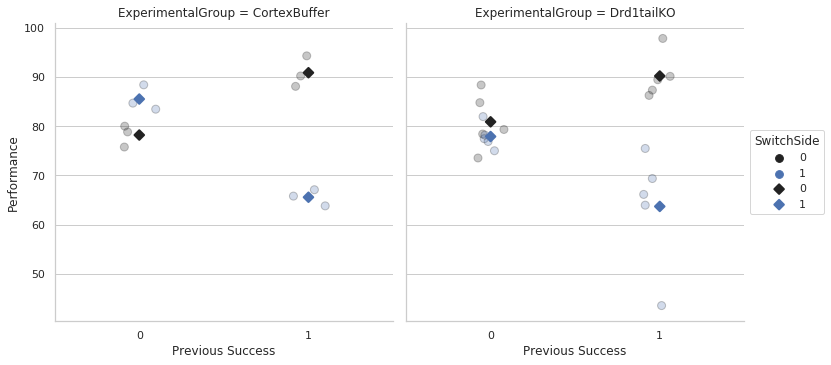

In [39]:
sns.set_style('whitegrid')
grid = sns.FacetGrid(prev_trial_df, col="ExperimentalGroup", sharex=False, sharey=True, height=5, col_wrap=5)
grid = grid.map_dataframe(sns.stripplot, x="PrevTrialSuccess", y="Performance", hue="SwitchSide", dodge=False, jitter=True,
                          alpha=.25, zorder=1, size=8,
                          linewidth=1)
grid = grid.map_dataframe(sns.pointplot, x="PrevTrialSuccess", y="Performance", hue="SwitchSide",
                          dodge=0, join=False,
                          markers="D", scale=1, ci=None)
plt.legend(loc='center left',bbox_to_anchor=(1,0.5), title="SwitchSide")
grid.axes[0].set_xlabel('Previous Success')
grid.axes[1].set_xlabel('Previous Success')
grid.axes[0].set_ylabel('Performance')
plt.savefig(outputDir + 'EffectOfPreviousTrial_' + protocol + '_' + str(low_perc) + '-' + str(high_perc) + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

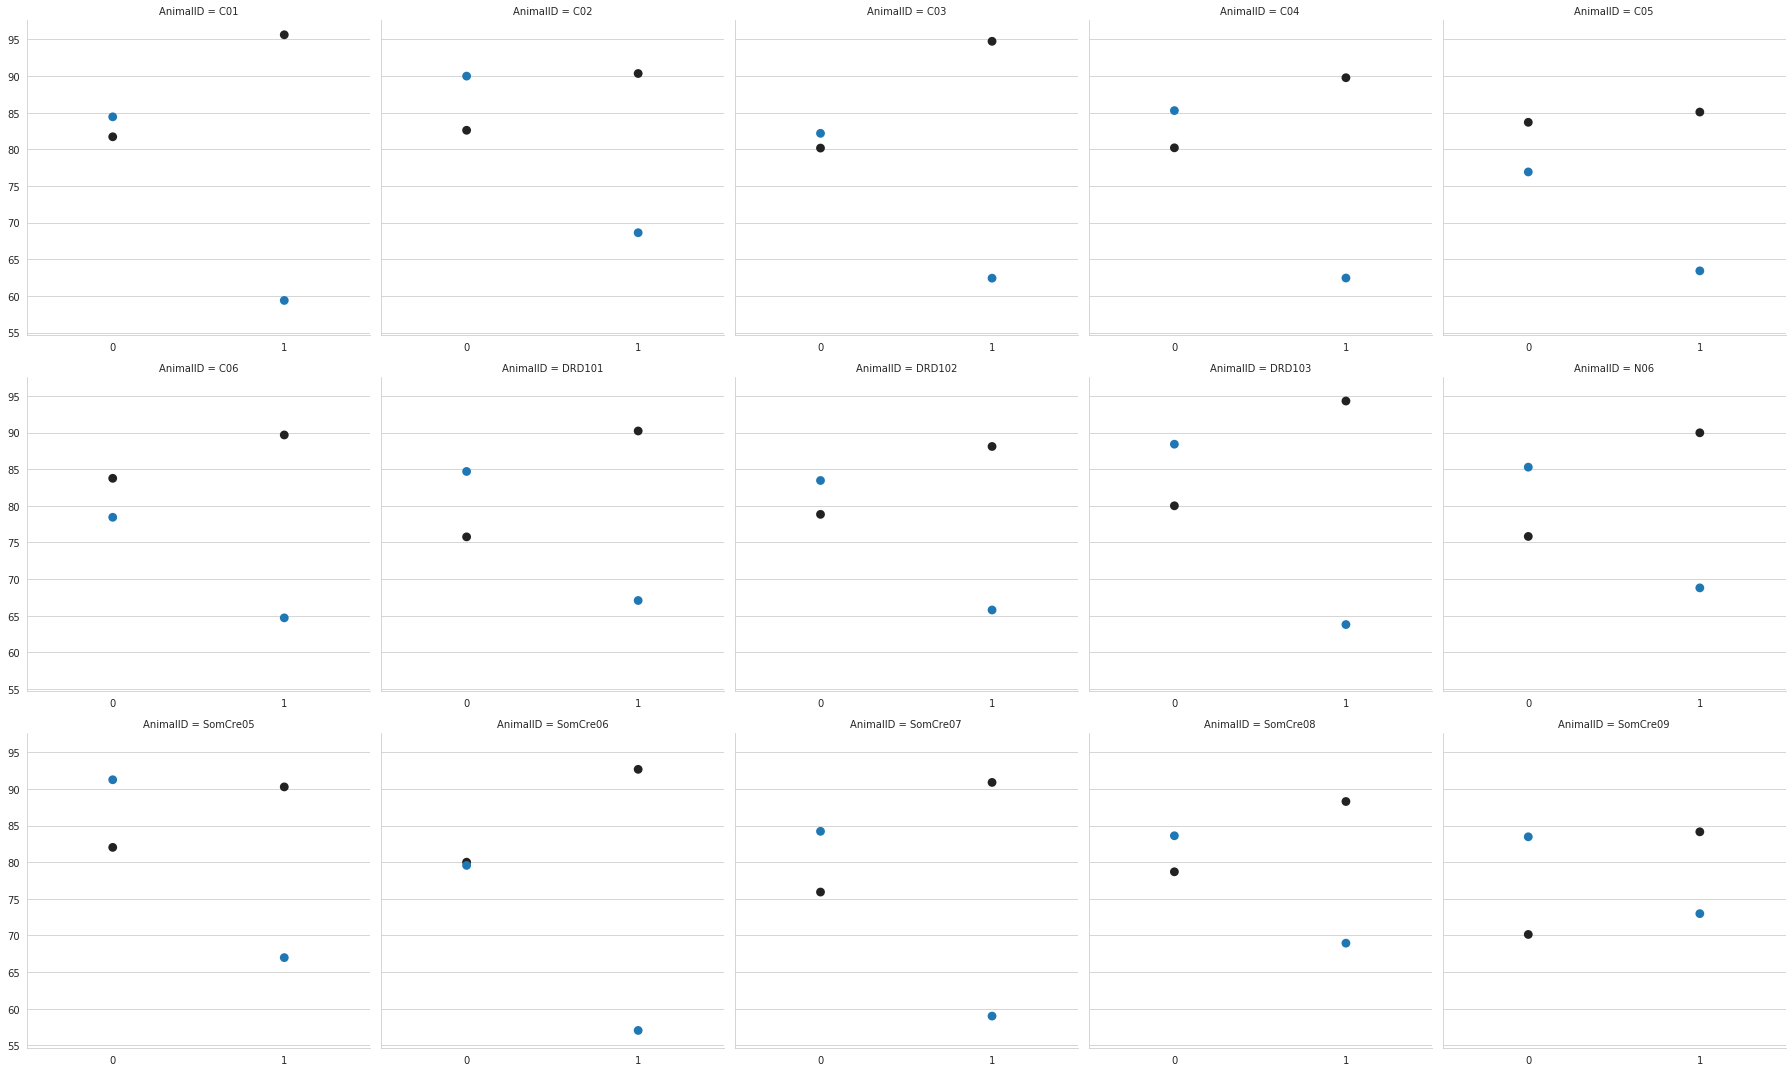

In [131]:
# plot all animals
grid = sns.FacetGrid(prev_trial_df, col="AnimalID", sharex=False, sharey=True, height=5, col_wrap=5)
#grid.fig.tight_layout()
#grid.set_xticklabels(rotation=45, horizontalalignment="right")
grid.map_dataframe(sns.pointplot, x="PrevTrialSuccess", y="Performance", hue="SwitchSide", join=False)

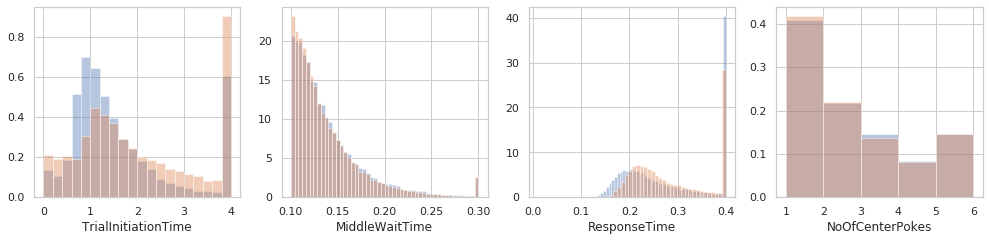

In [81]:
protocol = 'Auditory'
expgroup = '6OHDAtail'
df = df_to_plot[df_to_plot.Protocol == protocol]
# collapse values
df.loc[df.TrialInitiationTime > 4, 'TrialInitiationTime'] = 4
df.loc[df.MiddleWaitTime > .3, 'MiddleWaitTime'] = .3
df.loc[df.ResponseTime > .4, 'ResponseTime'] = .4
df.loc[df.NoOfCenterPokes > 6, 'NoOfCenterPokes'] = 6


sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 4, figsize=(17, 3.5))
ax = axs.ravel()

sns.distplot(df[df.ExperimentalGroup == 'CortexBuffer'].TrialInitiationTime, kde=False, ax=ax[0], bins=20, norm_hist=True)
sns.distplot(df[df.ExperimentalGroup == expgroup].TrialInitiationTime, kde=False, ax=ax[0], bins=20, norm_hist=True)

sns.distplot(df[df.ExperimentalGroup == 'CortexBuffer'].MiddleWaitTime, kde=False, ax=ax[1], bins=50, norm_hist=True)
sns.distplot(df[df.ExperimentalGroup == expgroup].MiddleWaitTime, kde=False, ax=ax[1], bins=50, norm_hist=True)

sns.distplot(df[df.ExperimentalGroup == 'CortexBuffer'].ResponseTime, kde=False, ax=ax[2], bins=50, norm_hist=True)
sns.distplot(df[df.ExperimentalGroup == expgroup].ResponseTime, kde=False, ax=ax[2], bins=50, norm_hist=True)

sns.distplot(df[df.ExperimentalGroup == 'CortexBuffer'].NoOfCenterPokes, kde=False, ax=ax[3], bins=5, norm_hist=True)
sns.distplot(df[df.ExperimentalGroup == expgroup].NoOfCenterPokes, kde=False, ax=ax[3], bins=5, norm_hist=True)

plt.savefig(outputDir + 'Times_' + protocol + '.pdf',
            transparent=True, bbox_inches='tight')

In [77]:
df.CenterPortDuration.describe()

count    37983.000000
mean         0.112153
std          0.047780
min          0.100000
25%          0.100000
50%          0.100000
75%          0.100000
max          0.300000
Name: CenterPortDuration, dtype: float64

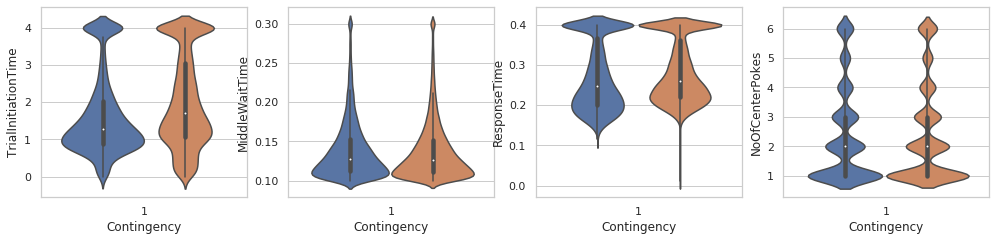

In [82]:
# try to do the boxplots / violinplots
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 4, figsize=(17, 3.5))
ax = axs.ravel()
sns.violinplot(x = 'Contingency', y = 'TrialInitiationTime', hue='ExperimentalGroup', data = df, ax=ax[0])
ax[0].get_legend().remove()
sns.violinplot(x = 'Contingency', y = 'MiddleWaitTime', hue='ExperimentalGroup', data = df, ax=ax[1])
ax[1].get_legend().remove()
sns.violinplot(x = 'Contingency', y = 'ResponseTime', hue='ExperimentalGroup', data = df, ax=ax[2])
ax[2].get_legend().remove()
sns.violinplot(x = 'Contingency', y = 'NoOfCenterPokes', hue='ExperimentalGroup', data = df, ax=ax[3])
ax[3].get_legend().remove()

In [ ]:
# 

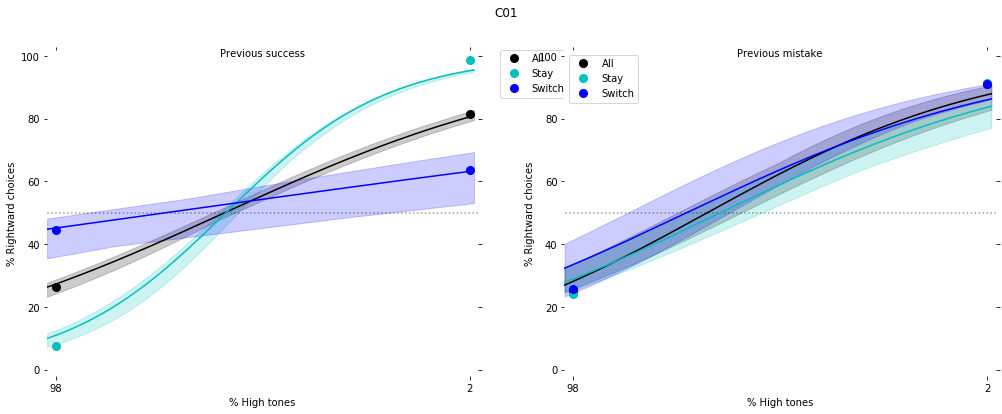

In [29]:
# check the effect of the last trial on the choice.
# select data for those sessions where the performance is between 70 and 85 %
protocol = 'Auditory'
low_perc = 70
high_perc = 85
Perf_condition = (df_to_plot.CurrentPastPerformance > low_perc) & (df_to_plot.CurrentPastPerformance < high_perc)


animal = 'C01'
pulledData = df_to_plot[(df_to_plot.Protocol == protocol) & Perf_condition & (df_to_plot.AnimalID == animal)]

# Plot differences if it the mouse has to switch, and if the previous trial was a success or not
# generate a list of the conditions, colors and labels
CondList = [(pulledData.PrevTrialSuccess==1),
            (pulledData.PrevTrialSuccess==1) & (pulledData['SwitchSide']==0),
            (pulledData.PrevTrialSuccess==1) & (pulledData['SwitchSide']==1),
            (pulledData.PrevTrialSuccess==0),
            (pulledData.PrevTrialSuccess==0) & (pulledData['SwitchSide']==0),
            (pulledData.PrevTrialSuccess==0) & (pulledData['SwitchSide']==1)
            ]
ColorList = ['k', 'c', 'b', 'k', 'c', 'b']
LabelList = ['All', 'Stay', 'Switch', 'All', 'Stay', 'Switch']
AxsOrder = [0,0,0,1,1,1]
SubplotTitles = ['Previous success', 'Previous mistake']
# plot
fig, axs = plt.subplots(1,2,figsize=(17, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
    ax.text(50,100, SubplotTitles[i], horizontalalignment='center')
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, _ =\
    cuf.PP_ProcessExperiment(pulledData[condition], bootstrap=5)
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i])
lgd = plt.legend()
plt.suptitle(animal)
plt.show(fig)

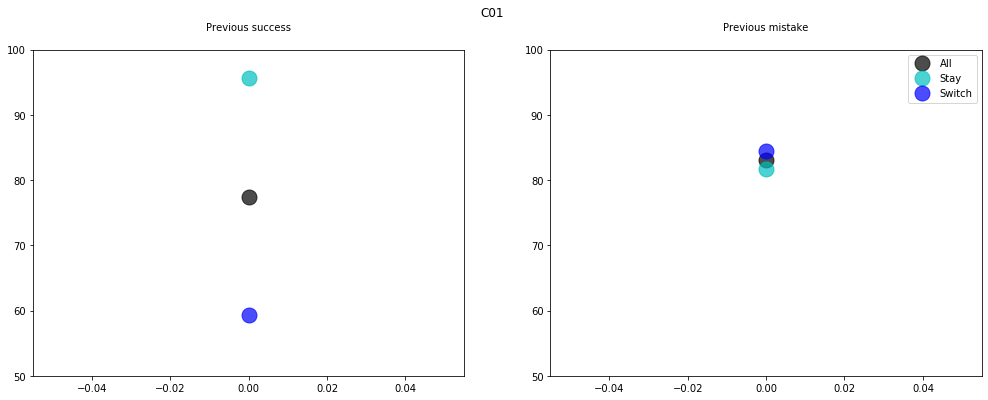

In [50]:
# plot
fig, axs = plt.subplots(1,2,figsize=(17, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    #ax.hlines(50, -0.2, 0.2, linestyles='dotted' , alpha=0.4)
    ax.text(0,103, SubplotTitles[i], horizontalalignment='center')
    ax.set_ylim(50,100)
for i, condition in enumerate(CondList):
    axs[AxsOrder[i]].plot(0, np.mean(pulledData[condition].FirstPokeCorrect) * 100,
                          'o', color=ColorList[i], label=LabelList[i], markersize=15, alpha=0.7)
lgd = plt.legend()
plt.suptitle(animal)
plt.show(fig)

In [16]:
# DEPRECATED *****

# Make a column with the group each mouse is in


def AssignToGroup(df):
    # Copy the AnimalIDList
    #AnimalIDList = ['C01', 'C02', 'C03', 'N01', 'N02', 'N03', 'N05']
    AnimalIDList = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'N06']
    # Create a vector here that is like the AnimalIDList
    #AnimalGroup = ['CortexBuffer', 'CortexBuffer', 'CortexBuffer', 'NMDA', 'NMDA', 'NMDA', 'NMDA']
    AnimalGroup = ['CortexBuffer', 'CortexBuffer', 'CortexBuffer', '6OHDA', '6OHDA', '6OHDA', '6OHDA']
    # Index position
    IndxPos = AnimalIDList.index(df['AnimalID'])
    return AnimalGroup[IndxPos]



AnimalsDF['Injection'] = AnimalsDF.apply(AssignToGroup, axis=1)

In [62]:
# Calculate the performance based on these trials only
EasyDF = AnimalsDF[conditions]

# calculate the cumulative performance
def CumPerCalculator(df):
    firstpokecorrect = df['FirstPokeCorrect']
    correct_cp = np.cumsum(firstpokecorrect == 1)
    incorrect_cp = np.cumsum(firstpokecorrect == 0)
    cumper = 100 * correct_cp / (correct_cp + incorrect_cp)
    return cumper

CumPerList = []
for Sid in pd.unique(EasyDF['SessionID']):
    CumPerList.append(CumPerCalculator(EasyDF[EasyDF['SessionID']==Sid]))
# flatten the list of lists
EasyDF['CumulativePerformance'] = np.array(list(chain(*[x for x in CumPerList])))


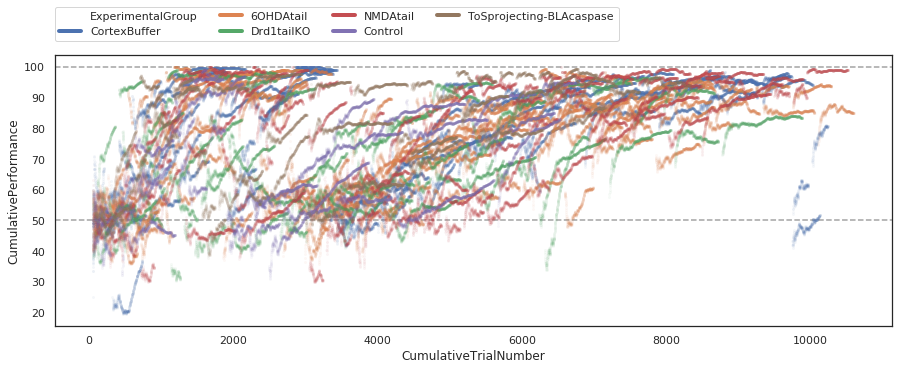

In [64]:
# remove the trials at the beginning of the session because it makes it noisy
condition4 = EasyDF['TrialIndex'] > 50

# remove the Aud_Psycho
condition5 = ~(EasyDF['Protocol'] == 'Aud_Psycho')

fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
ax.axhline(100, ls='--', alpha=0.4, color='k')
sns.lineplot(x='CumulativeTrialNumber', y='CumulativePerformance', data=EasyDF[np.logical_and(condition4, condition5)],
             hue='ExperimentalGroup', marker=".", alpha=0.05, markeredgewidth=0, linewidth=0,
             units="AnimalID", estimator=None)

lgd = plt.legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + 'CumulativePerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#### Analyze specific sessions

In [31]:
# Group sessions by type
protToGroup = 'Aud_Psycho'
stimToGroup = 'Right'
pulledData = AnimalsDF[(AnimalsDF['Protocol']==protToGroup) & (AnimalsDF['Stimulation']==stimToGroup)]

PlotsTitle = protToGroup + '_' + stimToGroup


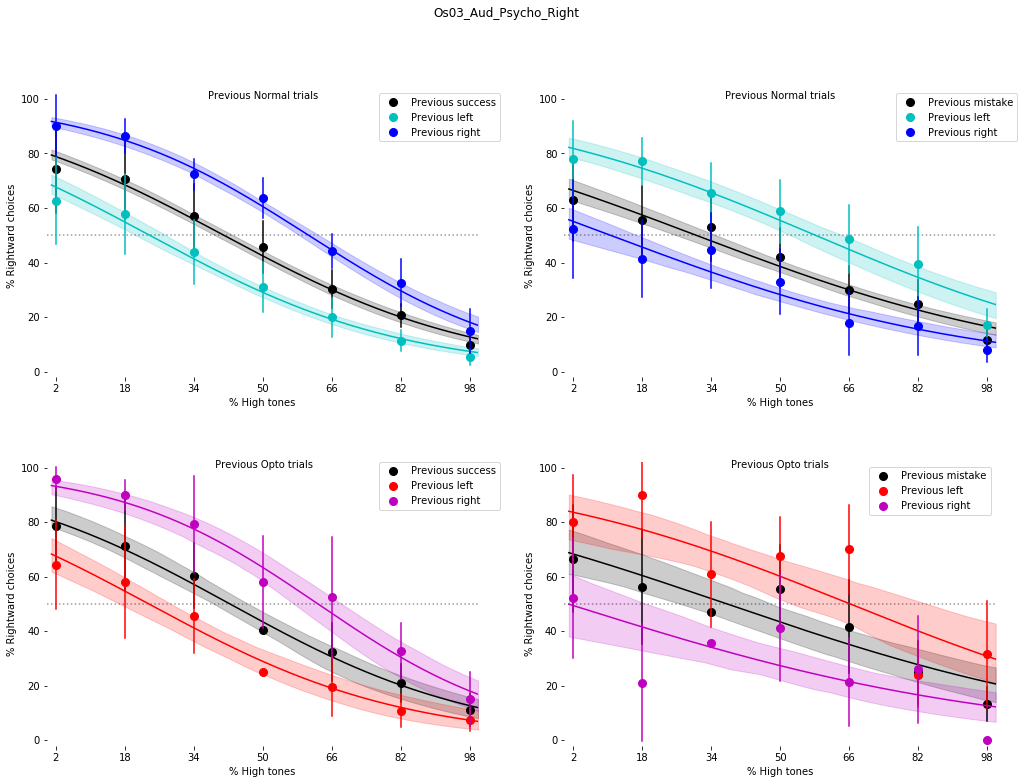

In [32]:
# Check responses to where the previous trial was (L or R) and previous success
PrevTrialSuccess = np.insert(np.array(pulledData['FirstPokeCorrect'][:-1]), 0, np.nan)
PrevTrialSide = np.insert(np.array(pulledData['TrialSide'][:-1]), 0, np.nan)
PrevOptoCondition = np.insert(np.array(pulledData['OptoStim'][:-1]), 0, np.nan)
# generate a list of the conditions, colors and labels
CondList = [(PrevOptoCondition==0) & (PrevTrialSuccess==1),
            (PrevOptoCondition==0) & (PrevTrialSuccess==1) & (PrevTrialSide==1),
            (PrevOptoCondition==0) & (PrevTrialSuccess==1) & (PrevTrialSide==2),
            (PrevOptoCondition==0) & (PrevTrialSuccess==0),
            (PrevOptoCondition==0) & (PrevTrialSuccess==0) & (PrevTrialSide==1),
            (PrevOptoCondition==0) & (PrevTrialSuccess==0) & (PrevTrialSide==2),
            (PrevOptoCondition==1) & (PrevTrialSuccess==1),
            (PrevOptoCondition==1) & (PrevTrialSuccess==1) & (PrevTrialSide==1),
            (PrevOptoCondition==1) & (PrevTrialSuccess==1) & (PrevTrialSide==2),
            (PrevOptoCondition==1) & (PrevTrialSuccess==0),
            (PrevOptoCondition==1) & (PrevTrialSuccess==0) & (PrevTrialSide==1),
            (PrevOptoCondition==1) & (PrevTrialSuccess==0) & (PrevTrialSide==2)]
ColorList = ['k', 'c', 'b', 'k', 'c', 'b','k', 'r', 'm', 'k', 'r', 'm']
LabelList = ['Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right',\
             'Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right']
AxsOrder = [0,0,0,1,1,1,2,2,2,3,3,3]
SubplotTitles = ['Previous Normal trials', 'Previous Normal trials', ' Previous Opto trials', 'Previous Opto trials',]
# plot
fig, axs = plt.subplots(2,2,figsize=(17, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
    ax.text(50,100, SubplotTitles[i], horizontalalignment='center')
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB =\
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)
plt.show(fig)

In [22]:
pulledData[condition]

,AnimalID,CenterPortDuration,Contingency,CumulativePerformance,FirstPoke,FirstPokeCorrect,OptoStim,Outcomes,PreviousChoice,Protocol,...,SessionTime,Stimulation,SwitchSide,TrialEvents,TrialHighPerc,TrialIndex,TrialSequence,TrialSide,TrialStartTimestamp,TrialStates
8243,Ot03,0.2,1,81.818182,2.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr10 17:04,Right,0,"{'Port2Out': 13.4641, 'Port3In': 13.7342000000...",2.0,54,7.0,2.0,442.8032,"{'Punish': [nan, nan], 'WaitForResponse': [13...."
8622,Ot03,0.2,1,75.483871,1.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': 1.5248, 'Tup': [1.304, 1.9156, 1....",82.0,155,2.0,1.0,1310.3586,"{'Punish': [nan, nan], 'WaitForResponse': [1.5..."
8746,Ot03,0.2,1,73.835125,2.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,0,"{'Port2Out': [0.2605, 1.3077999999999999], 'Tu...",18.0,279,6.0,2.0,2399.2494,"{'Punish': [nan, nan], 'WaitForResponse': [1.3..."
8782,Ot03,0.2,1,74.920635,1.0,0.0,0.0,0.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,0,"{'Port2Out': [0.6073, 1.5582], 'Port2In': [0.1...",34.0,315,5.0,2.0,2641.9858,"{'Punish': [0.888, 3.888], 'WaitForResponse': ..."
8794,Ot03,0.2,1,74.617737,1.0,1.0,1.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': 0.7432000000000001, 'Port2In': 0....",82.0,327,2.0,1.0,2704.2392,"{'Punish': [nan, nan], 'WaitForResponse': [0.7..."
8871,Ot03,0.2,1,74.009901,1.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': [0.1731, 0.7647], 'Tup': [0.7366,...",98.0,404,1.0,1.0,3130.9387,"{'Punish': [nan, nan], 'WaitForResponse': [0.7..."
8937,Ot03,0.2,1,73.617021,2.0,0.0,1.0,0.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': [0.129, 0.3712, 1.4578, 2.2376], ...",82.0,470,2.0,1.0,3526.9308,"{'Punish': [0.6781, 3.6780999999999997], 'Wait..."
8963,Ot03,0.2,1,72.782258,1.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': [0.5776, 1.3668, 1.4332, 2.2259],...",98.0,496,1.0,1.0,3785.6409,"{'Punish': [nan, nan], 'WaitForResponse': [2.2..."
8973,Ot03,0.2,1,72.332016,1.0,0.0,0.0,0.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,0,"{'Port2Out': 12.4845, 'Port2In': 12.265, 'Tup'...",2.0,506,7.0,2.0,3989.3998,"{'Punish': [12.786100000000001, 15.78610000000..."
8976,Ot03,0.2,1,71.905697,1.0,0.0,0.0,0.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,0,"{'Port2Out': [49.916599999999995, 51.1585], 'P...",50.0,509,4.0,2.0,4069.6394,"{'Punish': [51.4601, 54.4601], 'WaitForRespons..."
